In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import zipfile

def extract_zip_file(file_path, extract_to):
    try:
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
            print(f"Extracted ZIP: {file_path}")
        return True
    except Exception as e:
        print(f"Error extracting {file_path}: {e}")
        return False
# Usage:
initial_file = '/content/Nutrition5k_Dataset_Unzipped/Images.zip'
destination = '/content/Nutrition5k_Dataset_Images_Unzipped'
extract_zip_file(initial_file, destination)

Extracted ZIP: /content/Nutrition5k_Dataset_Unzipped/Images.zip


True

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
df = pd.read_csv("/content/dish_manual_captions.csv")

# Show basic info
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3490 entries, 0 to 3489
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   dish_id  3490 non-null   object
 1   caption  3490 non-null   object
dtypes: object(2)
memory usage: 54.7+ KB
None
           dish_id                                            caption
0  dish_1561662216  This plate contains 3.4g soy sauce, 2.1g garli...
1  dish_1561662054  This plate contains 0.3g pepper, 12.0g white r...
2  dish_1562008979  This plate contains 0.2g jalapenos, 1.5g lemon...
3  dish_1560455030  This plate contains 55.0g cherry tomatoes, 29....
4  dish_1558372433  This plate contains 143.0g deprecated. It prov...


# **Display the total no. of images**

In [ ]:
import os

# Path to the main folder containing subfolders for each dish
folder_path = '/content/Nutrition5k_Dataset_images_Unzipped/realsense_overhead'

# Count only directories (subfolders)
num_subfolders = len([f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))])

print(f"Number of images in the folder: {num_subfolders}")


Number of images in the folder: 3490


# **Check Image Availability**

In [ ]:
image_folder = "/content/Nutrition5k_Dataset_images_Unzipped/realsense_overhead"

# Update path to point to a folder instead of a .jpg file
df['image_folder_path'] = df['dish_id'].apply(lambda x: os.path.join(image_folder, x))

# Check if the folder exists
df['folder_exists'] = df['image_folder_path'].apply(os.path.isdir)

# Find missing folders
missing_folders = df[~df['folder_exists']]
print(f"Missing folders: {len(missing_folders)}")


Missing folders: 0


# **Extract Nutrition Info from Captions**

In [ ]:
import re

def extract_nutrition(text, nutrient):
    match = re.search(r"(\d+\.?\d*)\s*kcal.*?(\d+\.?\d*)g\s*protein.*?(\d+\.?\d*)g\s*fat.*?(\d+\.?\d*)g\s*carbohydrates", text, re.IGNORECASE)
    if not match:
        return None
    values = dict(zip(['kcal', 'protein', 'fat', 'carbs'], map(float, match.groups())))
    return values.get(nutrient)

# Add nutrition columns
df['kcal'] = df['caption'].apply(lambda x: extract_nutrition(x, 'kcal'))
df['protein'] = df['caption'].apply(lambda x: extract_nutrition(x, 'protein'))
df['fat'] = df['caption'].apply(lambda x: extract_nutrition(x, 'fat'))
df['carbs'] = df['caption'].apply(lambda x: extract_nutrition(x, 'carbs'))

print(df[['kcal', 'protein', 'fat', 'carbs']].describe())


              kcal      protein          fat        carbs
count  3490.000000  3490.000000  3490.000000  3490.000000
mean    254.832264    17.798309    12.835415    19.164327
std     216.551499    19.626048    13.436414    21.264939
min       0.000000     0.000000     0.000000     0.000000
25%      84.225000     2.300000     2.100000     6.100000
50%     209.750000    11.500000     9.200000    15.200000
75%     372.275000    27.400000    19.100000    27.300000
max    3943.300000   147.500000   106.300000   844.600000


# **Visualize Nutrition Distributions**

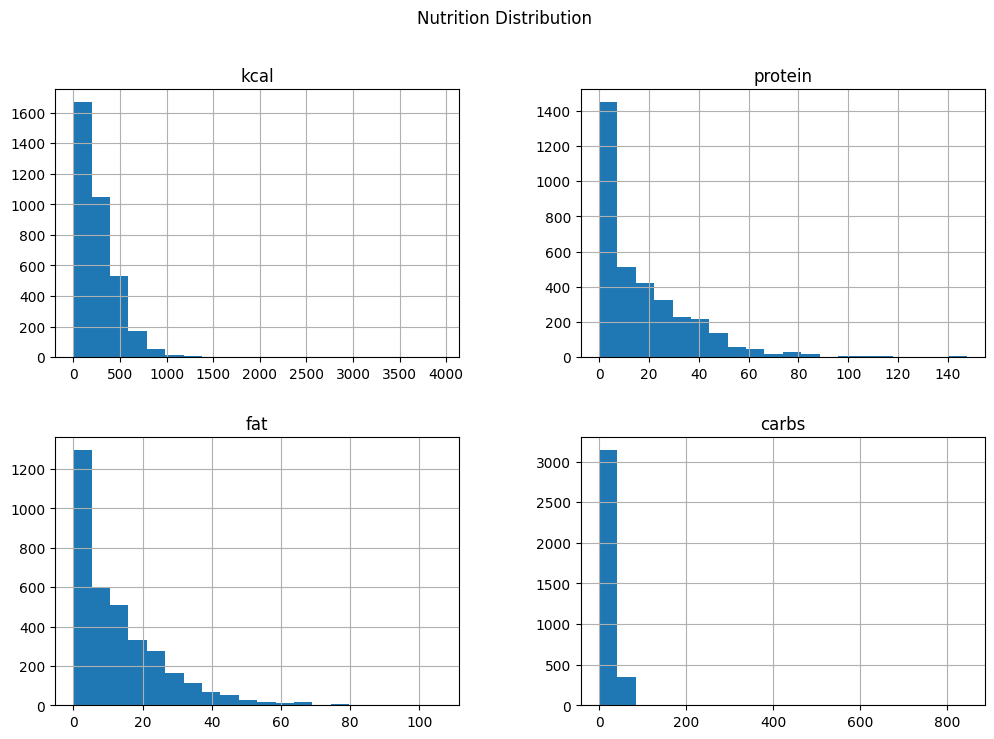

In [ ]:
# Histograms
df[['kcal', 'protein', 'fat', 'carbs']].hist(bins=20, figsize=(12, 8))
plt.suptitle('Nutrition Distribution')
plt.show()

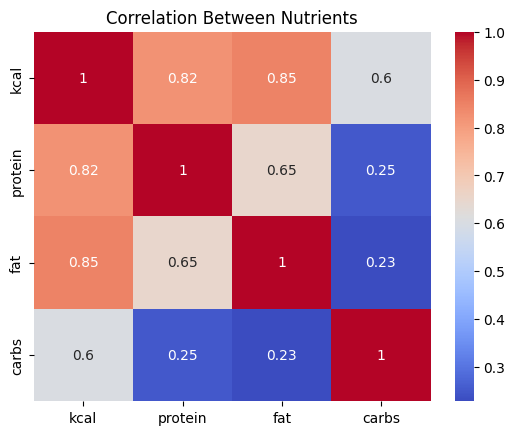

In [ ]:
# Correlation heatmap
sns.heatmap(df[['kcal', 'protein', 'fat', 'carbs']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Between Nutrients")
plt.show()

# **Display Top 3 Ingredients**

In [ ]:
from collections import Counter

def extract_ingredients(text):
    if "contains" not in text:
        return []
    try:
        ingredient_text = text.split("This plate contains")[1].split("It provides")[0]
    except IndexError:
        return []

    ingredients = []
    for x in ingredient_text.split(","):
        if "g" in x:
            parts = x.strip().split("g", 1)
            if len(parts) > 1 and parts[1].strip():
                ingredients.append(parts[1].strip())
    return ingredients

# Extract ingredient lists
df['ingredients'] = df['caption'].apply(extract_ingredients)

# Flatten the list of ingredients into a single list
all_ingredients = [item for sublist in df['ingredients'] for item in sublist]

# Count ingredient occurrences
ingredient_counts = Counter(all_ingredients)

# Get the top 3 most common ingredients
top_3 = ingredient_counts.most_common(3)

# Display the result
for i, (ingredient, count) in enumerate(top_3, 1):
    print(f"{i}. {ingredient} ({count} times)")


1. olive oil (1461 times)
2. salt (1325 times)
3. garlic (904 times)


# **Merging the images with their captions**

In [ ]:
import pandas as pd
import os
import re

# Load captions CSV
captions_df = pd.read_csv('/content/dish_manual_captions.csv')

# Update image path to match your directory structure
base_image_dir = '/content/Nutrition5k_Dataset_Images_Unzipped/realsense_overhead'
captions_df['image_path'] = captions_df['dish_id'].apply(
    lambda x: os.path.join(base_image_dir, x, 'rgb.png')
)

# Adjust regex or handle missing nutrition information
def extract_labels(caption):
    match = re.search(
        r"approximately ([\d.]+) kcal, ([\d.]+)g protein, ([\d.]+)g fat, and ([\d.]+)g carbohydrates",
        caption
    )
    if match:
        return list(map(float, match.groups()))
    else:
        # Add logic to handle missing or malformed captions
        return [None, None, None, None]

# Optionally: Fill missing values instead of dropping rows
captions_df[['calories', 'protein', 'fat', 'carbs']] = captions_df['caption'].apply(
    lambda x: pd.Series(extract_labels(x))
)

captions_df.fillna({'calories': 0, 'protein': 0, 'fat': 0, 'carbs': 0}, inplace=True)


# Save the structured dataset
output_path = '/content/nutrition5k_regression_data.csv'
captions_df.to_csv(output_path, index=False)

print(f"Saved merged file to: {output_path}")


Saved merged file to: /content/nutrition5k_regression_data.csv


In [ ]:
df_merged = pd.read_csv('/content/nutrition5k_regression_data.csv')
df_merged.head()

,dish_id,caption,image_path,calories,protein,fat,carbs
0,dish_1561662216,"This plate contains 3.4g soy sauce, 2.1g garli...",/content/Nutrition5k_Dataset_Images_Unzipped/r...,300.8,18.6,12.4,28.2
1,dish_1561662054,"This plate contains 0.3g pepper, 12.0g white r...",/content/Nutrition5k_Dataset_Images_Unzipped/r...,419.4,25.9,23.8,26.4
2,dish_1562008979,"This plate contains 0.2g jalapenos, 1.5g lemon...",/content/Nutrition5k_Dataset_Images_Unzipped/r...,382.9,35.3,22.2,10.2
3,dish_1560455030,"This plate contains 55.0g cherry tomatoes, 29....",/content/Nutrition5k_Dataset_Images_Unzipped/r...,20.6,1.0,0.1,4.6
4,dish_1558372433,This plate contains 143.0g deprecated. It prov...,/content/Nutrition5k_Dataset_Images_Unzipped/r...,74.4,20.0,0.3,0.4


# **Models Implementation**

In [ ]:
pip install transformers torchvision


# **BLIP Regression using all dataset in training**

In [ ]:
import os
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from transformers import BlipProcessor, BlipModel
from torchvision import transforms
from tqdm import tqdm

# -----------------------------
# Config
# -----------------------------
CSV_PATH = '/content/nutrition5k_regression_data.csv'
BATCH_SIZE = 4
NUM_EPOCHS = 2
LEARNING_RATE = 2e-5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# -----------------------------
# Dataset
# -----------------------------
class NutritionDataset(Dataset):
    def __init__(self, csv_path, processor):
        self.df = pd.read_csv(csv_path)
        self.processor = processor
        self.transform = transforms.Compose([
            transforms.Resize((384, 384)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = row['image_path']
        caption = row['caption']
        label = torch.tensor([row['calories'], row['protein'], row['fat'], row['carbs']], dtype=torch.float32)

        # Load and preprocess image
        image = Image.open(image_path).convert('RGB')
        image = self.transform(image)

        # Tokenize text
        text_inputs = self.processor(text=caption, return_tensors="pt", padding='max_length', truncation=True, max_length=128)

        return image, text_inputs['input_ids'].squeeze(0), text_inputs['attention_mask'].squeeze(0), label


# -----------------------------
# Model
# -----------------------------
class BLIPRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.blip = BlipModel.from_pretrained("Salesforce/blip-image-captioning-base")
        embedding_dim = self.blip.config.text_config.hidden_size  # Get the actual embedding size (768)

        self.regressor = nn.Sequential(
            nn.Linear(512, 512),  # 512 is the actual size of text_embeds
            nn.ReLU(),
            nn.Linear(512, 4)
        )


    def forward(self, pixel_values, input_ids, attention_mask):
        outputs = self.blip(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values,
            return_dict=True
        )
        fused = outputs.text_embeds
        preds = self.regressor(fused)
        return preds



# -----------------------------
# Collate Function
# -----------------------------
def collate_fn(batch):
    images, input_ids, attention_masks, labels = zip(*batch)
    return (
        torch.stack(images),
        torch.stack(input_ids),
        torch.stack(attention_masks),
        torch.stack(labels)
    )


# -----------------------------
# Training
# -----------------------------
def train():
    processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
    dataset = NutritionDataset(CSV_PATH, processor)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

    model = BLIPRegressor().to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.MSELoss()

    model.train()
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
            images, input_ids, attention_mask, labels = [b.to(DEVICE) for b in batch]

            optimizer.zero_grad()
            outputs = model(images, input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(dataloader)
        print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}")

    torch.save(model.state_dict(), "blip_regressor.pth")
    print("Model saved as blip_regressor.pth")


if __name__ == '__main__':
    train()

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

`BlipModel` is going to be deprecated in future release, please use `BlipForConditionalGeneration`, `BlipForQuestionAnswering` or `BlipForImageTextRetrieval` depending on your usecase.


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-image-captioning-base and are newly initialized: ['logit_scale', 'text_model.embeddings.LayerNorm.bias', 'text_model.embeddings.LayerNorm.weight', 'text_model.embeddings.position_embeddings.weight', 'text_model.embeddings.word_embeddings.weight', 'text_model.encoder.layer.0.attention.output.LayerNorm.bias', 'text_model.encoder.layer.0.attention.output.LayerNorm.weight', 'text_model.encoder.layer.0.attention.output.dense.bias', 'text_model.encoder.layer.0.attention.output.dense.weight', 'text_model.encoder.layer.0.attention.self.key.bias', 'text_model.encoder.layer.0.attention.self.key.weight', 'text_model.encoder.layer.0.attention.self.query.bias', 'text_model.encoder.layer.0.attention.self.query.weight', 'text_model.encoder.layer.0.attention.self.value.bias', 'text_model.encoder.layer.0.attention.self.value.weight', 'text_model.encoder.layer.0.crossattention.output.LayerNorm.bias', 'text_model.

# **Clean the captions from Nutrition Info**

In [ ]:
import pandas as pd
import re

# Function to clean captions
def clean_caption(caption):
    # Remove patterns that match nutrition information
    caption = re.sub(r'\d+(\.\d+)?\s*(kcal|g\s*protein|g\s*fat|g\s*carbohydrates.|g\s*protein|g\s*salt|g\s*fiber|g\s*sugar)', '', caption)

    # Remove the part starting from "It provides approximately" till the end
    caption = re.sub(r'\s*It provides approximately.*', '', caption)

    # Optional: Remove any redundant spaces after cleaning
    caption = re.sub(r'\s+', ' ', caption).strip()

    return caption

# Load your dataset
csv_path = '/content/nutrition5k_regression_data.csv'
df = pd.read_csv(csv_path)

# Clean the captions
df['cleaned_caption'] = df['caption'].apply(clean_caption)

# Show the first few rows to verify the cleaning
print(df[['caption', 'cleaned_caption']].head())

# Optionally, save the cleaned dataset to a new CSV file
df.to_csv('/content/cleaned_nutrition5k.csv', index=False)


                                             caption  \
0  This plate contains 3.4g soy sauce, 2.1g garli...   
1  This plate contains 0.3g pepper, 12.0g white r...   
2  This plate contains 0.2g jalapenos, 1.5g lemon...   
3  This plate contains 55.0g cherry tomatoes, 29....   
4  This plate contains 143.0g deprecated. It prov...   

                                     cleaned_caption  
0  This plate contains 3.4g soy sauce, 2.1g garli...  
1  This plate contains 0.3g pepper, 12.0g white r...  
2  This plate contains 0.2g jalapenos, 1.5g lemon...  
3  This plate contains 55.0g cherry tomatoes, 29....  
4             This plate contains 143.0g deprecated.  


# **2nd Phase Best Model**

In [ ]:
import os
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from transformers import BlipProcessor, BlipModel
from torchvision import transforms
from tqdm import tqdm
from torch.utils.data import random_split
import re


# -----------------------------
# Config
# -----------------------------
CSV_PATH = '/content/cleaned_nutrition5k.csv'  # Use cleaned dataset
BATCH_SIZE = 16
NUM_EPOCHS = 10
LEARNING_RATE = 2e-5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# -----------------------------
# Dataset
# -----------------------------
class NutritionDataset(Dataset):
    def __init__(self, csv_path, processor):
        self.df = pd.read_csv(csv_path)
        self.processor = processor
        self.transform = transforms.Compose([
            transforms.Resize((384, 384)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = row['image_path']
        caption = row['cleaned_caption']  # Use cleaned caption
        label = torch.tensor([row['calories'], row['protein'], row['fat'], row['carbs']], dtype=torch.float32)

        # Load and preprocess image
        image = Image.open(image_path).convert('RGB')
        image = self.transform(image)

        # Tokenize text
        text_inputs = self.processor(text=caption, return_tensors="pt", padding='max_length', truncation=True, max_length=128)

        return image, text_inputs['input_ids'].squeeze(0), text_inputs['attention_mask'].squeeze(0), label


# -----------------------------
# Model
# -----------------------------
class BLIPRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.blip = BlipModel.from_pretrained("Salesforce/blip-image-captioning-base")

        self.regressor = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 4)
        )

    def forward(self, pixel_values, input_ids, attention_mask):
        outputs = self.blip(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values,
            return_dict=True
        )
        fused = torch.cat([outputs.image_embeds, outputs.text_embeds], dim=1)  # Combine both embeddings
        preds = self.regressor(fused)
        return preds



# -----------------------------
# Collate Function
# -----------------------------
def collate_fn(batch):
    images, input_ids, attention_masks, labels = zip(*batch)
    return (
        torch.stack(images),
        torch.stack(input_ids),
        torch.stack(attention_masks),
        torch.stack(labels)
    )


# -----------------------------
# Training
# -----------------------------
def train():
    processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
    dataset = NutritionDataset(CSV_PATH, processor)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size

    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

    model = BLIPRegressor().to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.MSELoss()

    model.train()
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
            images, input_ids, attention_mask, labels = [b.to(DEVICE) for b in batch]

            optimizer.zero_grad()
            outputs = model(images, input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}")

    torch.save(model.state_dict(), "blip_regressor.pth")
    print("Model saved as blip_regressor.pth")


def evaluate(model, dataloader, num_samples_to_show=5):
    model.eval()
    total_loss = 0
    criterion = nn.MSELoss()

    predictions = []
    targets = []

    with torch.no_grad():
        for batch in dataloader:
            images, input_ids, attention_mask, labels = [b.to(DEVICE) for b in batch]
            outputs = model(images, input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            predictions.extend(outputs.cpu().numpy())
            targets.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    print(f"\nTest Loss: {avg_loss:.4f}")

    # Show some predictions
    print("\nSample Predictions vs True Values:")
    for i in range(min(num_samples_to_show, len(predictions))):
        pred = predictions[i]
        true = targets[i]
        print(f"Predicted: {pred.round(2)} | True: {true.round(2)}")


if __name__ == '__main__':
    processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
    dataset = NutritionDataset(CSV_PATH, processor)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

    model = BLIPRegressor().to(DEVICE)

    # Train the model
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.MSELoss()

    model.train()
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
            images, input_ids, attention_mask, labels = [b.to(DEVICE) for b in batch]

            optimizer.zero_grad()
            outputs = model(images, input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}")

    torch.save(model.state_dict(), "blip_regressor.pth")
    print("Model saved as blip_regressor.pth")

    # Evaluate the model
    evaluate(model, test_loader, num_samples_to_show=5)


`BlipModel` is going to be deprecated in future release, please use `BlipForConditionalGeneration`, `BlipForQuestionAnswering` or `BlipForImageTextRetrieval` depending on your usecase.
Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-image-captioning-base and are newly initialized: ['logit_scale', 'text_model.embeddings.LayerNorm.bias', 'text_model.embeddings.LayerNorm.weight', 'text_model.embeddings.position_embeddings.weight', 'text_model.embeddings.word_embeddings.weight', 'text_model.encoder.layer.0.attention.output.LayerNorm.bias', 'text_model.encoder.layer.0.attention.output.LayerNorm.weight', 'text_model.encoder.layer.0.attention.output.dense.bias', 'text_model.encoder.layer.0.attention.output.dense.weight', 'text_model.encoder.layer.0.attention.self.key.bias', 'text_model.encoder.layer.0.attention.self.key.weight', 'text_model.encoder.layer.0.attention.self.query.bias', 'text_model.encoder.layer.0.attention.self.query.weight', 'text_mo

Epoch 1 - Loss: 28168.7198


Epoch 2/10: 100%|██████████| 175/175 [06:33<00:00,  2.25s/it]


Epoch 2 - Loss: 23938.3476


Epoch 3/10: 100%|██████████| 175/175 [06:33<00:00,  2.25s/it]


Epoch 3 - Loss: 14278.6074


Epoch 4/10: 100%|██████████| 175/175 [06:32<00:00,  2.25s/it]


Epoch 4 - Loss: 10286.0099


Epoch 5/10: 100%|██████████| 175/175 [06:32<00:00,  2.24s/it]


Epoch 5 - Loss: 7158.3879


Epoch 6/10: 100%|██████████| 175/175 [06:32<00:00,  2.24s/it]


Epoch 6 - Loss: 5201.8662


Epoch 7/10: 100%|██████████| 175/175 [06:32<00:00,  2.25s/it]


Epoch 7 - Loss: 4329.9098


Epoch 8/10: 100%|██████████| 175/175 [06:33<00:00,  2.25s/it]


Epoch 8 - Loss: 3846.3851


Epoch 9/10: 100%|██████████| 175/175 [06:34<00:00,  2.25s/it]


Epoch 9 - Loss: 3531.0087


Epoch 10/10: 100%|██████████| 175/175 [06:33<00:00,  2.25s/it]


Epoch 10 - Loss: 2941.0744
Model saved as blip_regressor.pth

Test Loss: 2312.5269

Sample Predictions vs True Values:
Predicted: [359.05  27.46  18.44  24.53] | True: [280.9  35.5   2.9  22.4]
Predicted: [63.17  4.83  3.24  4.38] | True: [97.5  2.   0.2 21. ]
Predicted: [85.26  6.52  4.37  5.89] | True: [122.   14.2  11.5   7.9]
Predicted: [509.51  38.97  26.18  34.78] | True: [561.7  28.9  14.5  79.8]
Predicted: [412.5   31.55  21.19  28.17] | True: [397.6  28.2  25.7  14.2]


In [ ]:
import os
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from transformers import BlipProcessor, BlipModel
from torchvision import transforms
from tqdm import tqdm
from torch.utils.data import random_split
import re


# -----------------------------
# Config
# -----------------------------
CSV_PATH = '/kaggle/input/cleaned-nutrition5ks/cleaned_nutrition5k.csv'  # Use cleaned dataset
BATCH_SIZE = 16
NUM_EPOCHS = 20
LEARNING_RATE = 2e-5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# -----------------------------
# Dataset
# -----------------------------
class NutritionDataset(Dataset):
    def __init__(self, csv_path, processor):
        self.df = pd.read_csv(csv_path)
        self.processor = processor
        self.transform = transforms.Compose([
            transforms.Resize((384, 384)),
            transforms.ToTensor(),
        ])
        self.mean = torch.tensor([254.8323, 17.7983, 12.8354, 19.1643])
        self.std = torch.tensor([216.5515, 19.6260, 13.4364, 21.2649])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = row['image_path']
        caption = row['cleaned_caption']  # Use cleaned caption
        label = torch.tensor([row['calories'], row['protein'], row['fat'], row['carbs']], dtype=torch.float32)
        label = (label - self.mean) / self.std

        # Load and preprocess image
        image = Image.open(image_path).convert('RGB')
        image = self.transform(image)

        # Tokenize text
        text_inputs = self.processor(text=caption, return_tensors="pt", padding='max_length', truncation=True, max_length=128)

        return image, text_inputs['input_ids'].squeeze(0), text_inputs['attention_mask'].squeeze(0), label


# -----------------------------
# Model
# -----------------------------
class BLIPRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.blip = BlipModel.from_pretrained("Salesforce/blip-image-captioning-base")

        for param in self.blip.parameters():
            param.requires_grad = True

        self.regressor = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 4)
        )

    def forward(self, pixel_values, input_ids, attention_mask):
        outputs = self.blip(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values,
            return_dict=True
        )
        fused = torch.cat([outputs.image_embeds, outputs.text_embeds], dim=1)  # Combine both embeddings
        preds = self.regressor(fused)
        return preds



# -----------------------------
# Collate Function
# -----------------------------
def collate_fn(batch):
    images, input_ids, attention_masks, labels = zip(*batch)
    return (
        torch.stack(images),
        torch.stack(input_ids),
        torch.stack(attention_masks),
        torch.stack(labels)
    )


# -----------------------------
# Training
# -----------------------------
def train():
    processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
    dataset = NutritionDataset(CSV_PATH, processor)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size

    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

    model = BLIPRegressor().to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.MSELoss()

    model.train()
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
            images, input_ids, attention_mask, labels = [b.to(DEVICE) for b in batch]

            optimizer.zero_grad()
            outputs = model(images, input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}")

    torch.save(model.state_dict(), "blip_regressor.pth")
    print("Model saved as blip_regressor.pth")


def evaluate(model, dataloader, num_samples_to_show=5):
    model.eval()
    total_loss = 0
    criterion = nn.MSELoss()

    predictions = []
    targets = []

    with torch.no_grad():
        for batch in dataloader:
            images, input_ids, attention_mask, labels = [b.to(DEVICE) for b in batch]
            outputs = model(images, input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            predictions.extend(outputs.cpu().numpy())
            targets.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    print(f"\nTest Loss: {avg_loss:.4f}")

    # Show some predictions
    print("\nSample Predictions vs True Values:")
    for i in range(min(num_samples_to_show, len(predictions))):
        pred = predictions[i]
        true = targets[i]

        # Denormalize
        pred = pred * dataset.std.numpy() + dataset.mean.numpy()
        true = true * dataset.std.numpy() + dataset.mean.numpy()

        print(f"Predicted: {pred.round(2)} | True: {true.round(2)}")


if __name__ == '__main__':
    processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
    dataset = NutritionDataset(CSV_PATH, processor)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

    model = BLIPRegressor().to(DEVICE)

    # Train the model
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.MSELoss()

    model.train()
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
            images, input_ids, attention_mask, labels = [b.to(DEVICE) for b in batch]

            optimizer.zero_grad()
            outputs = model(images, input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}")

    torch.save(model.state_dict(), "blip_regressor.pth")
    print("Model saved as blip_regressor.pth")

    # Evaluate the model
    evaluate(model, test_loader, num_samples_to_show=5)


Epoch 1/20: 100%|██████████| 175/175 [07:10<00:00,  2.46s/it]


Epoch 1 - Loss: 0.9382


Epoch 2/20: 100%|██████████| 175/175 [07:10<00:00,  2.46s/it]


Epoch 2 - Loss: 0.6521


Epoch 3/20: 100%|██████████| 175/175 [07:11<00:00,  2.47s/it]


Epoch 3 - Loss: 0.5433


Epoch 4/20: 100%|██████████| 175/175 [07:12<00:00,  2.47s/it]


Epoch 4 - Loss: 0.4889


Epoch 5/20: 100%|██████████| 175/175 [07:12<00:00,  2.47s/it]


Epoch 5 - Loss: 0.4508


Epoch 6/20: 100%|██████████| 175/175 [07:12<00:00,  2.47s/it]


Epoch 6 - Loss: 0.4349


Epoch 7/20: 100%|██████████| 175/175 [07:11<00:00,  2.47s/it]


Epoch 7 - Loss: 0.4089


Epoch 8/20: 100%|██████████| 175/175 [07:10<00:00,  2.46s/it]


Epoch 8 - Loss: 0.4138


Epoch 9/20: 100%|██████████| 175/175 [07:10<00:00,  2.46s/it]


Epoch 9 - Loss: 0.3717


Epoch 10/20: 100%|██████████| 175/175 [07:08<00:00,  2.45s/it]


Epoch 10 - Loss: 0.3328


Epoch 11/20: 100%|██████████| 175/175 [07:09<00:00,  2.45s/it]


Epoch 11 - Loss: 0.3095


Epoch 12/20: 100%|██████████| 175/175 [07:12<00:00,  2.47s/it]


Epoch 12 - Loss: 0.2930


Epoch 13/20: 100%|██████████| 175/175 [07:11<00:00,  2.47s/it]


Epoch 13 - Loss: 0.2729


Epoch 14/20: 100%|██████████| 175/175 [07:09<00:00,  2.46s/it]


Epoch 14 - Loss: 0.2558


Epoch 15/20: 100%|██████████| 175/175 [07:11<00:00,  2.46s/it]


Epoch 15 - Loss: 0.2267


Epoch 16/20: 100%|██████████| 175/175 [07:12<00:00,  2.47s/it]


Epoch 16 - Loss: 0.2181


Epoch 17/20: 100%|██████████| 175/175 [07:12<00:00,  2.47s/it]


Epoch 17 - Loss: 0.1953


Epoch 18/20: 100%|██████████| 175/175 [07:12<00:00,  2.47s/it]


Epoch 18 - Loss: 0.1882


Epoch 19/20: 100%|██████████| 175/175 [07:11<00:00,  2.47s/it]


Epoch 19 - Loss: 0.1945


Epoch 20/20: 100%|██████████| 175/175 [07:10<00:00,  2.46s/it]


Epoch 20 - Loss: 0.1746
Model saved as blip_regressor.pth

Test Loss: 0.1303

Sample Predictions vs True Values:
Predicted: [431.82  32.7   27.38  18.58] | True: [470.7  39.   25.4  21.1]
Predicted: [40.63  4.58  0.46  5.03] | True: [74.4  0.4  0.3 20. ]
Predicted: [315.34  26.06  20.88   7.47] | True: [245.8  29.1  24.9  13. ]
Predicted: [78.48  0.61  0.67 18.48] | True: [89.   0.9  0.3 23.2]
Predicted: [243.7   30.39  10.6    5.92] | True: [235.5  35.2   7.    2.7]


In [ ]:
# -----------------------------
# Load Model and Evaluate
# -----------------------------
from transformers import BlipProcessor

# Reload the processor and dataset
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
dataset = NutritionDataset(CSV_PATH, processor)

# Create test loader again
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
_, test_dataset = random_split(dataset, [train_size, test_size])
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# Reinitialize model and load saved weights
model = BLIPRegressor().to(DEVICE)
model.load_state_dict(torch.load("blip_regressor.pth", map_location=DEVICE))
model.eval()

# Evaluate
def evaluate(model, dataloader, mean, std, num_samples_to_show=5):
    model.eval()
    criterion = nn.MSELoss()
    total_loss = 0.0
    predictions = []
    targets = []

    with torch.no_grad():
        for batch in dataloader:
            images, input_ids, attention_mask, labels = [b.to(DEVICE) for b in batch]
            outputs = model(images, input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            predictions.extend(outputs.cpu().numpy())
            targets.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    print(f"\nTest Loss: {avg_loss:.4f}")
    print("\nSample Predictions vs True Values:")

    for i in range(min(num_samples_to_show, len(predictions))):
        pred = predictions[i] * std.numpy() + mean.numpy()
        true = targets[i] * std.numpy() + mean.numpy()
        print(f"Predicted: {pred.round(2)} | True: {true.round(2)}")

# Run evaluation
evaluate(model, test_loader, dataset.mean, dataset.std, num_samples_to_show=50)


`BlipModel` is going to be deprecated in future release, please use `BlipForConditionalGeneration`, `BlipForQuestionAnswering` or `BlipForImageTextRetrieval` depending on your usecase.
Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-image-captioning-base and are newly initialized: ['logit_scale', 'text_model.embeddings.LayerNorm.bias', 'text_model.embeddings.LayerNorm.weight', 'text_model.embeddings.position_embeddings.weight', 'text_model.embeddings.word_embeddings.weight', 'text_model.encoder.layer.0.attention.output.LayerNorm.bias', 'text_model.encoder.layer.0.attention.output.LayerNorm.weight', 'text_model.encoder.layer.0.attention.output.dense.bias', 'text_model.encoder.layer.0.attention.output.dense.weight', 'text_model.encoder.layer.0.attention.self.key.bias', 'text_model.encoder.layer.0.attention.self.key.weight', 'text_model.encoder.layer.0.attention.self.query.bias', 'text_model.encoder.layer.0.attention.self.query.weight', 'text_mo


Test Loss: 0.0566

Sample Predictions vs True Values:
Predicted: [274.09   7.75  10.99  39.83] | True: [290.7   9.9   8.9  44. ]
Predicted: [23.55  0.06  0.6   5.8 ] | True: [33.   0.8  0.2  7.8]
Predicted: [214.41  31.28   4.68   9.76] | True: [304.2  33.4   4.2  27.5]
Predicted: [163.06  17.9    7.27   7.98] | True: [182.   15.4   9.6   8.6]
Predicted: [224.93  16.85  12.53  13.74] | True: [257.   15.2  15.   15.3]
Predicted: [426.23  33.15  22.76  26.14] | True: [419.4  25.9  23.8  26.4]
Predicted: [208.88  11.44   8.24  24.16] | True: [252.7  10.4   9.2  31.4]
Predicted: [326.91  30.13  18.54  12.04] | True: [342.2  30.3  15.7  18.3]
Predicted: [477.72  26.65  24.71  41.96] | True: [511.7  28.9  24.1  44.7]
Predicted: [166.76  16.22   8.64   6.98] | True: [187.   17.4   8.8   8.6]
Predicted: [169.17   0.63   0.85  41.29] | True: [153.7   2.    0.5  39.5]
Predicted: [382.14  24.51  28.58  10.4 ] | True: [621.1  44.9  41.7  15.3]
Predicted: [708.5   72.97  36.85  24.26] | True: [919